In [ ]:
import os
import math
from dataclasses import dataclass
from typing import Tuple, Optional, Literal

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

from einops import rearrange
import torch.optim as optim
import torch.utils.data as data
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

## tqdm for loading bars
# from tqdm import tqdm
from tqdm.notebook import tqdm


plt.set_cmap('cividis')
%matplotlib inline
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "C:/Users/Miguel/Documents/Malky/research/data/mla_jax"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "C:/Users/Miguel/Documents/Malky/research/saved_models/mla_deepSeek_reverse"


# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Seed set to 42


Device: cuda:0


In [3]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    # 
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            # ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            # ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [5]:
@dataclass
class ModelArgs:
    """
    Data class for defining model arguments and hyperparameters.

    Attributes:
        max_batch_size (int): Maximum batch size.
        max_seq_len (int): Maximum sequence length.
        dtype (Literal["bf16", "fp8"]): Data type for computations.
        vocab_size (int): Vocabulary size.
        dim (int): Model dimension.
        inter_dim (int): Intermediate dimension for MLP layers.
        
        n_layers (int): Number of transformer layers.
     
        n_heads (int): Number of attention heads.
       
        q_lora_rank (int): LoRA rank for query projections.
        kv_lora_rank (int): LoRA rank for key-value projections.
        qk_nope_head_dim (int): Dimension for query-key projections without positional embeddings. size of the future predictions
        qk_rope_head_dim (int): Dimension for query-key projections with rotary embeddings.
        v_head_dim (int): Dimension for value projections.
        original_seq_len (int): Original sequence length.
        rope_theta (float): Base for rotary positional encoding.
        rope_factor (float): Scaling factor for extended sequence lengths.
        beta_fast (int): Fast beta correction factor.
        beta_slow (int): Slow beta correction factor.
        mscale (float): Scaling factor for extended attention.
    """
    max_batch_size: int = 1 # 8
    max_seq_len: int = 128 # 4096 * 4
    dtype: Literal["bf16", "fp8"] = "bf16"
    vocab_size: int = 10#102400 
    dim: int = 32 #2048
    inter_dim: int = 32# 10944
    n_layers = 1

    q_lora_rank: int = 4
    kv_lora_rank: int = 4 #512
    qk_nope_head_dim: int = 4# 128
    qk_rope_head_dim: int = 6# 64
    v_head_dim: int = 8 #128
    # yarn
    original_seq_len: int = 128 #4096
    rope_theta: float = 10000.0
    rope_factor: float = 40
    beta_fast: int = 32
    beta_slow: int = 1
    mscale: float = 1.


    input_dim:int = 2
    
    n_heads = 1
    
# k  = concat[k_nope,  k_pe] ==> concat [qk_nope_head_dim, qk_rope_head_dim]
# q =  concat [q_nope, q_pe] ==> concat[ qk_nope_head_dim, qk_rope_head_dim]
# v =  v_head_dim

In [6]:
def apply_rotary_emb(x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
    """
    Applies rotary positional embeddings to the input tensor.

    Args:
        x (torch.Tensor): Input tensor with positional embeddings to be applied.
        freqs_cis (torch.Tensor): Precomputed complex exponential values for positional embeddings.

    Returns:
        torch.Tensor: Tensor with rotary embeddings applied.
    """
    dtype = x.dtype
    x = torch.view_as_complex(x.float().view(*x.shape[:-1], -1, 2))
    freqs_cis = freqs_cis.view(1, x.size(1), 1, x.size(-1))
    y = torch.view_as_real(x * freqs_cis).flatten(3)
    return y.to(dtype)



def precompute_freqs_cis(args: ModelArgs) -> torch.Tensor:
    """
    Precomputes frequency-based complex exponential values for rotary positional embeddings.

    Args:
        args (ModelArgs): Model arguments containing positional embedding parameters.

    Returns:
        torch.Tensor: Precomputed complex exponential values for positional embeddings.
    """
    dim = args.qk_rope_head_dim
    seqlen = args.max_seq_len
    beta_fast = args.beta_fast
    beta_slow = args.beta_slow
    base = args.rope_theta
    factor = args.rope_factor

    def find_correction_dim(num_rotations, dim, base, max_seq_len):
        """
        Computes the correction dimension for a given number of rotations in the rotary positional embedding.

        Args:
            num_rotations (float): Number of rotations to compute the correction for.
            dim (int): Dimensionality of the embedding space.
            base (float): Base value for the exponential computation.
            max_seq_len (int): Maximum sequence length.

        Returns:
            float: The correction dimension based on the input parameters.
        """
        return dim * math.log(max_seq_len / (num_rotations * 2 * math.pi)) / (2 * math.log(base))

    def find_correction_range(low_rot, high_rot, dim, base, max_seq_len):
        """
        Computes the range of correction dimensions for rotary positional embeddings.

        Args:
            low_rot (float): Lower bound for the number of rotations.
            high_rot (float): Upper bound for the number of rotations.
            dim (int): Dimensionality of the embedding space.
            base (float): Base value for the exponential computation.
            max_seq_len (int): Maximum sequence length.

        Returns:
            Tuple[int, int]: The range of correction dimensions (low, high), clamped to valid indices.
        """
        low = math.floor(find_correction_dim(low_rot, dim, base, max_seq_len))
        high = math.ceil(find_correction_dim(high_rot, dim, base, max_seq_len))
        return max(low, 0), min(high, dim-1)

    def linear_ramp_factor(min, max, dim):
        """
        Computes a linear ramp function used to smooth values between a minimum and maximum range.

        Args:
            min (float): Minimum value for the ramp function.
            max (float): Maximum value for the ramp function.
            dim (int): Dimensionality of the ramp tensor.

        Returns:
            torch.Tensor: A tensor of shape (dim,) with values linearly interpolated between 0 and 1,
                clamped to the range [0, 1].
        """
        if min == max:
            max += 0.001
        linear_func = (torch.arange(dim, dtype=torch.float32) - min) / (max - min)
        ramp_func = torch.clamp(linear_func, 0, 1)
        return ramp_func

    freqs = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))
    if seqlen > args.original_seq_len:
        low, high = find_correction_range(beta_fast, beta_slow, dim, base, args.original_seq_len)
        smooth = 1 - linear_ramp_factor(low, high, dim // 2)
        freqs = freqs / factor * (1 - smooth) + freqs * smooth

    t = torch.arange(seqlen)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis

In [7]:
class MLAPos(nn.Module):
    """
    Multi-Headed Attention Layer (MLA).

    Attributes:
        dim (int): Dimensionality of the input features.
        n_heads (int): Number of attention heads.
        q_lora_rank (int): Rank for low-rank query projection.
        kv_lora_rank (int): Rank for low-rank key/value projection.
        qk_nope_head_dim (int): Dimensionality of non-positional query/key projections.
        qk_rope_head_dim (int): Dimensionality of rotary-positional query/key projections.
        qk_head_dim (int): Total dimensionality of query/key projections.
        v_head_dim (int): Dimensionality of value projections.
        softmax_scale (float): Scaling factor for softmax in attention computation.
    """
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.dim = args.dim
        self.n_heads = args.n_heads
        self.q_lora_rank = args.q_lora_rank
        self.kv_lora_rank = args.kv_lora_rank
        self.qk_nope_head_dim = args.qk_nope_head_dim
        self.qk_rope_head_dim = args.qk_rope_head_dim
        self.qk_head_dim = args.qk_nope_head_dim + args.qk_rope_head_dim
        self.v_head_dim = args.v_head_dim

        # Query
        if self.q_lora_rank == 0:
            self.wq = torch.nn.Linear(in_features=self.dim, out_features= self.n_heads * self.qk_head_dim) # normal Query (no latent space)
        else:
            self.wq_a = torch.nn.Linear(in_features = self.dim, out_features = self.q_lora_rank)  # latent space (Q reduced )
            self.q_norm = torch.nn.RMSNorm(normalized_shape = self.q_lora_rank)
            self.wq_b = torch.nn.Linear(in_features= self.q_lora_rank, out_features=self.n_heads * self.qk_head_dim)
        
        self.wkv_a = torch.nn.Linear(in_features=self.dim, out_features=self.kv_lora_rank + self.qk_rope_head_dim)
        self.kv_norm = torch.nn.RMSNorm(normalized_shape =self.kv_lora_rank)
        self.wkv_b = torch.nn.Linear(in_features=self.kv_lora_rank, out_features=self.n_heads * (self.qk_nope_head_dim + self.v_head_dim))


        self.wo = torch.nn.Linear(in_features=self.n_heads * self.v_head_dim, out_features= self.dim)
        
        self.softmax_scale = self.qk_head_dim ** -0.5
        if args.max_seq_len > args.original_seq_len:
            mscale = 0.1 * args.mscale * math.log(args.rope_factor) + 1.0
            self.softmax_scale = self.softmax_scale * mscale * mscale

        self._reset_parameters() 
       
            
    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation

        if self.q_lora_rank == 0:
            nn.init.xavier_uniform_(self.wq.weight)
            self.wq.bias.data.fill_(0)
        else:
            nn.init.xavier_uniform_(self.wq_a.weight)
            self.wq_a.bias.data.fill_(0)

            nn.init.xavier_uniform_(self.wq_b.weight)
            self.wq_b.bias.data.fill_(0)
        
        nn.init.xavier_uniform_(self.wkv_a.weight)
        self.wkv_a.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.wkv_b.weight)
        self.wkv_b.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.wo.weight)
        self.wo.bias.data.fill_(0)

    def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor], return_attention: bool= False):
        """
        Forward pass for the Multi-Headed Attention Layer (MLA).

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, dim).
            start_pos (int): Starting position in the sequence for caching.
            freqs_cis (torch.Tensor): Precomputed complex exponential values for rotary embeddings.
            mask (Optional[torch.Tensor]): Mask tensor to exclude certain positions from attention.

        Returns:
            torch.Tensor: Output tensor with the same shape as the input.
        """
        bsz, seqlen, _ = x.size()
        end_pos = start_pos + seqlen
        
        # Queries
        if self.q_lora_rank == 0:
            q = self.wq(x)
        
        else:
            # reduction (latent space) -> norm -> increse space 
            q = self.wq_b(self.q_norm(self.wq_a(x)))

        q = q.view(bsz, seqlen, self.n_heads, self.qk_head_dim) # batch, sequence lenght, number of heads, dimension
        
        q_nope, q_pe = torch.split(q, [self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1)
        q_pe = apply_rotary_emb(q_pe, freqs_cis)

        # KV -> keys , values
        kv = self.wkv_a(x) # get kv reduction
        kv, k_pe = torch.split(kv, [self.kv_lora_rank, self.qk_rope_head_dim], dim=-1)
        k_pe = apply_rotary_emb(k_pe.unsqueeze(2), freqs_cis)

        
      
        q = torch.cat([q_nope, q_pe], dim=-1) # concatenate [q^C, q^R]
        kv = self.wkv_b(self.kv_norm(kv)) # increase dimension
        kv = kv.view(bsz, seqlen, self.n_heads, self.qk_nope_head_dim + self.v_head_dim) # batch, sequence lenght, number of heads, dimension
        k_nope, v = torch.split(kv, [self.qk_nope_head_dim, self.v_head_dim], dim=-1) # k^C, v^C
        k = torch.cat([k_nope, k_pe.expand(-1, -1, self.n_heads, -1)], dim=-1) # concat[k^c, k^R]
        scores = torch.einsum("bshd,bthd->bsht", q, k) * self.softmax_scale
        
        
        if mask is not None:
            scores += mask.unsqueeze(1)
        scores = scores.softmax(dim=-1, dtype=torch.float32).type_as(x)
        
        
        
        x = torch.einsum("bsht,bthd->bshd", scores, v[:bsz, :end_pos])
        
        x = self.wo(x.flatten(2))

        if return_attention:
            return x, scores
        else:
            return x
    
# k  = concat[k_nope,  k_pe] ==> concat [qk_nope_head_dim, qk_rope_head_dim]
# q =  concat [q_nope, q_pe] ==> concat[ qk_nope_head_dim, qk_rope_head_dim]
# v =  v_head_dim

In [8]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) used as a feed-forward layer.

    Attributes:
        w1 (nn.Module): Linear layer for input-to-hidden transformation.
        w2 (nn.Module): Linear layer for hidden-to-output transformation.
        w3 (nn.Module): Additional linear layer for feature transformation.
    """
    def __init__(self, dim: int, inter_dim: int):
        """
        Initializes the MLP layer.

        Args:
            dim (int): Input and output dimensionality.
            inter_dim (int): Hidden layer dimensionality.
        """
        super().__init__()
        self.w1 = torch.nn.Linear(in_features=dim, out_features=inter_dim)
        self.w2 = torch.nn.Linear(in_features=inter_dim, out_features=dim)
        self.w3 = torch.nn.Linear(in_features=dim, out_features=inter_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the MLP layer.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after MLP computation.
        """
        return self.w2(F.silu(self.w1(x)) * self.w3(x)) #Output=W_2(SiLU(W_1x) ⊙ (W_3x))

In [9]:
class BlockPos(nn.Module):
    """
    Transformer block combining attention and feed-forward layers.

    Attributes:
        attn (nn.Module): Attention layer (MLA).
        ffn (nn.Module): Feed-forward network (MLP or MoE).
        attn_norm (nn.Module): Layer normalization for attention.
        ffn_norm (nn.Module): Layer normalization for feed-forward network.
    """
    def __init__(self, layer_id: int, args: ModelArgs):
        """
        Initializes the Transformer block.

        Args:
            layer_id (int): Layer index in the transformer.
            args (ModelArgs): Model arguments containing block parameters.
        """
        super().__init__()
        self.attn = MLAPos(args)
        self.ffn = MLP(args.dim, args.inter_dim) #if layer_id < args.n_dense_layers else MoE(args)
        self.attn_norm = torch.nn.RMSNorm(args.dim)
        self.ffn_norm = torch.nn.RMSNorm(args.dim)

      

    def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor]) -> torch.Tensor:
        """
        Forward pass for the Transformer block.

        Args:
            x (torch.Tensor): Input tensor.
            start_pos (int): Starting position in the sequence.
            freqs_cis (torch.Tensor): Precomputed complex exponential values for rotary embeddings.
            mask (Optional[torch.Tensor]): Mask tensor to exclude certain positions from attention.

        Returns:
            torch.Tensor: Output tensor after block computation.
        """
        x = x + self.attn(self.attn_norm(x), start_pos, freqs_cis, mask)
        x = self.ffn_norm(x)
        x = x + self.ffn(x)
        return x

In [10]:
   
class TransformerPos(nn.Module):
    """
    Transformer model with positional embeddings, multiple layers, and output projection.

    Attributes:
        max_seq_len (int): Maximum sequence length for the transformer.
        embed (nn.Module): Embedding layer for input tokens.
        layers (torch.nn.ModuleList): List of transformer blocks.
        norm (nn.Module): Layer normalization applied after all blocks.
        head (nn.Module): Output projection layer mapping to vocabulary size.
        freqs_cis (torch.Tensor): Precomputed complex exponential values for rotary embeddings.
    """
    def __init__(self, args: ModelArgs):
        """
        Initializes the Transformer model.

        Args:
            args (ModelArgs): Model arguments containing transformer parameters.
        """
        super().__init__()
        self.max_seq_len = args.max_seq_len
        # self.embed = torch.nn.Linear(args.vocab_size, args.dim)

        
        self.embed = torch.nn.Linear(in_features = args.input_dim, out_features= args.dim)
        self.layers = torch.nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(BlockPos(layer_id, args))
        # self.norm = torch.nn.RMSNorm(args.dim)
        # self.head = torch.nn.Linear(args.dim, args.vocab_size, dtype=torch.get_default_dtype())
        self.register_buffer("freqs_cis", precompute_freqs_cis(args), persistent=False)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        
        nn.init.xavier_uniform_(self.embed.weight)
        self.embed.bias.data.fill_(0)
       


    def forward(self, tokens: torch.Tensor, mask: Optional[torch.Tensor], start_pos: int = 0):
        """
        Forward pass for the Transformer model.

        Args:
            tokens (torch.Tensor): Input tensor of token IDs with shape (batch_size, seq_len).
            start_pos (int, optional): Starting position in the sequence for rotary embeddings. Defaults to 0.

        Returns:
            torch.Tensor: Logits tensor of shape (batch_size, vocab_size).
        """

        
        seqlen = tokens.size(1)  
        h = self.embed(tokens)

        freqs_cis = self.freqs_cis[start_pos:start_pos+seqlen]

    
        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)

    
        # h = self.norm(h)[:, -1]
        # h = self.norm(h)
        # print("h print after norm",h.shape)
        # logits = self.head(h)

        
        # return logits

        return h
    

    def get_attention_maps(self, tokens: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        seqlen = tokens.size(1)
        h = self.embed(tokens)
        freqs_cis = self.freqs_cis[start_pos:start_pos+seqlen]

        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.attn(x=h, start_pos = start_pos, freqs_cis =freqs_cis, mask = mask, return_attention = True)
            attention_maps.append(rearrange(attn_map, "b s h d -> b h s d"))
            h = layer(h, start_pos, freqs_cis, mask)
        return attention_maps

ModelArgs(max_batch_size=1, max_seq_len=10, dtype='bf16', vocab_size=10, dim=32, inter_dim=32, q_lora_rank=4, kv_lora_rank=4, qk_nope_head_dim=4, qk_rope_head_dim=6, v_head_dim=8, original_seq_len=128, rope_theta=10000.0, rope_factor=40, beta_fast=32, beta_slow=1, mscale=1.0, input_dim=2)
Output shape: torch.Size([1, 10, 32])
torch.Size([1, 1, 10, 10])


<Figure size 640x480 with 0 Axes>

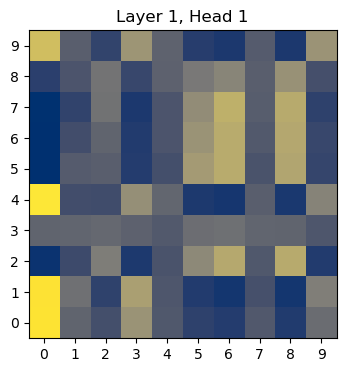

In [11]:
attn_impl= "absorb"#Literal["naive", "absorb"] = "naive" # naive -> train, absorb -> inference
args = ModelArgs()


batch_size = 1
seq_len = 10
x= torch.randn(batch_size, seq_len, 2)
args.max_seq_len = seq_len

print(args)

transpos = TransformerPos(args)
output  = transpos(tokens = x, mask = None, start_pos = 0)

print("Output shape:", output.shape)
# print("attention ", attention.shape)

att = transpos.get_attention_maps(tokens = x, mask = None, start_pos = 0)
for i in att:
    print(i.shape)
plot_attention_maps(x, att, idx=0)

del attn_impl, args, batch_size, seq_len, x, transpos, output, att

import gc
gc.collect() 
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [20]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [201]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, args):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        
        self.transformer = TransformerPos(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            nn.LayerNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(args.dim, args.vocab_size)
        )
        self.args = args

    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
        return attention_maps
    
    def configure_optimizers(self):

        optimizer = optim.Adam(self.parameters(), lr=5e-4)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=50,
                                             max_iters=50)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]




        #  return torch.optim.Adam(self.parameters(), lr=0.001)
        # optimizer = optim.Adam(self.parameters(), lr=0.01)
        
        # # Apply lr scheduler per step
        # warmup_epochs = 5
        # total_epochs = 50

        # warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
        # cosine_scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
        # scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

        # return {
        #     "optimizer": optimizer,
        #     "lr_scheduler": {
        #         "scheduler": scheduler,
        #         "interval": "step"  # Adjust learning rate per step
        #     }
        # }
       
       
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError
    

In [202]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [203]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

In [204]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([6, 9, 3, 6, 4, 1, 4, 9, 2, 4, 3, 7, 1, 2, 3, 3])
Labels:     tensor([3, 3, 2, 1, 7, 3, 4, 2, 9, 4, 1, 4, 6, 3, 9, 6])


In [205]:
class ReversePredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
       
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.args.vocab_size).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, mask=None, start_pos=0) 

        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

   
        # Logging
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)


        return loss, acc


    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
  
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [208]:
def train_reverse():
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=20,
                         gradient_clip_val=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:

        args = ModelArgs()
        args.input_dim = train_loader.dataset.num_categories
        args.vocab_size = train_loader.dataset.num_categories
        args.max_batch_size = 128
        
        model = ReversePredictor(args)
        trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    

    model = model.to(device)
    return model, result

In [209]:
reverse_model, reverse_result = train_reverse()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type           | Params | Mode 
-------------------------------------------------------
0 | transformer | TransformerPos | 4.5 K  | train
1 | output_net  | Sequential     | 1.4 K  | train
-------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


data ==> 10 32


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [210]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  30.84%
Test accuracy: 30.80%


In [211]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=train_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data, mask=None, start_pos=0)

In [212]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

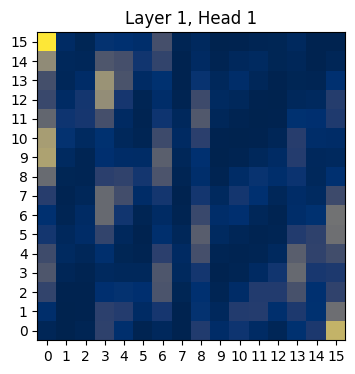

In [213]:
plot_attention_maps(data_input, attention_maps, idx=0)

#### Set Anomaly Detection

Modelo

In [51]:
@dataclass
class ModelArgs:
    """
    Data class for defining model arguments and hyperparameters.

    Attributes:
        max_batch_size (int): Maximum batch size.
        max_seq_len (int): Maximum sequence length.
        dtype (Literal["bf16", "fp8"]): Data type for computations.
        vocab_size (int): Vocabulary size.
        dim (int): Model dimension.
        inter_dim (int): Intermediate dimension for MLP layers.
        
        n_layers (int): Number of transformer layers.
     
        n_heads (int): Number of attention heads.
       
        q_lora_rank (int): LoRA rank for query projections.
        kv_lora_rank (int): LoRA rank for key-value projections.
        qk_nope_head_dim (int): Dimension for query-key projections without positional embeddings. size of the future predictions
        qk_rope_head_dim (int): Dimension for query-key projections with rotary embeddings.
        v_head_dim (int): Dimension for value projections.
        original_seq_len (int): Original sequence length.
        rope_theta (float): Base for rotary positional encoding.
        rope_factor (float): Scaling factor for extended sequence lengths.
        beta_fast (int): Fast beta correction factor.
        beta_slow (int): Slow beta correction factor.
        mscale (float): Scaling factor for extended attention.
    """
    max_batch_size: int = 1 # 8
    max_seq_len: int = 128 # 4096 * 4
    dtype: Literal["bf16", "fp8"] = "bf16"
    vocab_size: int = 10#102400 
    dim: int = 256 #2048
    inter_dim: int = 512# 10944
    n_layers = 1

    q_lora_rank: int = 64
    kv_lora_rank: int = 64 #512
    qk_nope_head_dim: int = 32# 128
    qk_rope_head_dim: int = 32# 64
    v_head_dim: int = 64 #128
    # yarn
    original_seq_len: int = 128 #4096
    rope_theta: float = 10000.0
    rope_factor: float = 40
    beta_fast: int = 32
    beta_slow: int = 1
    mscale: float = 1.


    input_dim:int = 2
    
    n_heads = 1
    
# k  = concat[k_nope,  k_pe] ==> concat [qk_nope_head_dim, qk_rope_head_dim]
# q =  concat [q_nope, q_pe] ==> concat[ qk_nope_head_dim, qk_rope_head_dim]
# v =  v_head_dim

In [5]:
class MLA(nn.Module):
    """
    Multi-Headed Attention Layer (MLA).

    Attributes:
        dim (int): Dimensionality of the input features.
        n_heads (int): Number of attention heads.
        q_lora_rank (int): Rank for low-rank query projection.
        kv_lora_rank (int): Rank for low-rank key/value projection.
        qk_head_dim (int): Total dimensionality of query/key projections. 
        v_head_dim (int): Dimensionality of value projections.
        softmax_scale (float): Scaling factor for softmax in attention computation.
    """
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.dim = args.dim
        self.n_heads = args.n_heads
        self.q_lora_rank = args.q_lora_rank
        self.kv_lora_rank = args.kv_lora_rank
        self.qk_head_dim = args.qk_nope_head_dim 
        self.v_head_dim = args.v_head_dim

        # Query
        if self.q_lora_rank == 0:
            self.wq = torch.nn.Linear(in_features=self.dim, out_features= self.n_heads * self.qk_head_dim) # normal Query (no latent space)
        else:
            self.wq_a = torch.nn.Linear(in_features = self.dim, out_features = self.q_lora_rank)  # latent space (Q reduced )
            self.q_norm = torch.nn.RMSNorm(normalized_shape = self.q_lora_rank)
            self.wq_b = torch.nn.Linear(in_features= self.q_lora_rank, out_features=self.n_heads * self.qk_head_dim)
        
        self.wkv_a = torch.nn.Linear(in_features=self.dim, out_features=self.kv_lora_rank)
        self.kv_norm = torch.nn.RMSNorm(normalized_shape =self.kv_lora_rank)
        self.wkv_b = torch.nn.Linear(in_features=self.kv_lora_rank, out_features=self.n_heads * (self.qk_head_dim + self.v_head_dim))



        self.wo = torch.nn.Linear(in_features=self.n_heads * self.v_head_dim, out_features= self.dim)
        
        self.softmax_scale = self.qk_head_dim ** -0.5

     
        # include K,Q,V
    
    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation

        if self.q_lora_rank == 0:
            nn.init.xavier_uniform_(self.wq.weight)
            self.wq.bias.data.fill_(0)
        else:
            nn.init.xavier_uniform_(self.wq_a.weight)
            self.wq_a.bias.data.fill_(0)

            nn.init.xavier_uniform_(self.wq_b.weight)
            self.wq_b.bias.data.fill_(0)
        
        nn.init.xavier_uniform_(self.wkv_a.weight)
        self.wkv_a.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.wkv_b.weight)
        self.wkv_b.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.wo.weight)
        self.wo.bias.data.fill_(0)

    def forward(self, x: torch.Tensor, start_pos: int,  mask: Optional[torch.Tensor],  return_attention: bool= False):
        """
        Forward pass for the Multi-Headed Attention Layer (MLA).

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, dim).
            start_pos (int): Starting position in the sequence for caching.
            mask (Optional[torch.Tensor]): Mask tensor to exclude certain positions from attention.

        Returns:
            torch.Tensor: Output tensor with the same shape as the input.
        """
 
        bsz, seqlen, _ = x.size()
        end_pos = start_pos + seqlen
        
        # Queries
        if self.q_lora_rank == 0:
            q = self.wq(x)
        else:
            # reduction (latent space) -> norm -> increse space 
            q = self.wq_b(self.q_norm(self.wq_a(x)))

        q = q.view(bsz, seqlen, self.n_heads, self.qk_head_dim) # batch, sequence lenght, number of heads, dimension
        
        # KV -> keys , values
        kv = self.wkv_a(x) # get kv reduction
     
        kv = self.wkv_b(self.kv_norm(kv)) # increase dimension
        kv = kv.view(bsz, seqlen, self.n_heads, self.qk_head_dim + self.v_head_dim) # batch, sequence lenght, number of heads, dimension
     
        k, v = torch.split(kv, [self.qk_head_dim, self.v_head_dim], dim=-1) # k^C, v^C
            
        scores = torch.einsum("bshd,bthd->bsht", q, k[:bsz, :end_pos]) * self.softmax_scale
        
        
        if mask is not None:
            scores += mask.unsqueeze(1)
        scores = scores.softmax(dim=-1, dtype=torch.float32).type_as(x) # score softmax of the scores and set the type as the same as the input x
                
        x = torch.einsum("bsht,bthd->bshd", scores, v[:bsz, :end_pos])
       
        x = self.wo(x.flatten(2))
        
       
        if return_attention:
            return x, scores
        else:
            return x

In [6]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) used as a feed-forward layer.

    Attributes:
        w1 (nn.Module): Linear layer for input-to-hidden transformation.
        w2 (nn.Module): Linear layer for hidden-to-output transformation.
        w3 (nn.Module): Additional linear layer for feature transformation.
    """
    def __init__(self, dim: int, inter_dim: int):
        """
        Initializes the MLP layer.

        Args:
            dim (int): Input and output dimensionality.
            inter_dim (int): Hidden layer dimensionality.
        """
        super().__init__()
        self.w1 = torch.nn.Linear(in_features=dim, out_features=inter_dim)
        self.w2 = torch.nn.Linear(in_features=inter_dim, out_features=dim)
        self.w3 = torch.nn.Linear(in_features=dim, out_features=inter_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the MLP layer.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after MLP computation.
        """
        return self.w2(F.silu(self.w1(x)) * self.w3(x)) #Output=W_2(SiLU(W_1x) ⊙ (W_3x))
    

class Block(nn.Module):
    """
    Transformer block combining attention and feed-forward layers.

    Attributes:
        attn (nn.Module): Attention layer (MLA).
        ffn (nn.Module): Feed-forward network (MLP or MoE).
        attn_norm (nn.Module): Layer normalization for attention.
        ffn_norm (nn.Module): Layer normalization for feed-forward network.
    """
    def __init__(self, layer_id: int, args: ModelArgs):
        """
        Initializes the Transformer block.

        Args:
            layer_id (int): Layer index in the transformer.
            args (ModelArgs): Model arguments containing block parameters.
        """
        super().__init__()
        self.attn = MLA(args)
        self.ffn = MLP(args.dim, args.inter_dim) #if layer_id < args.n_dense_layers else MoE(args)
        self.attn_norm = torch.nn.RMSNorm(args.dim)
        self.ffn_norm = torch.nn.RMSNorm(args.dim)

      

    def forward(self, x: torch.Tensor, start_pos: int, mask: Optional[torch.Tensor]) -> torch.Tensor:
        """
        Forward pass for the Transformer block.

        Args:
            x (torch.Tensor): Input tensor.
            start_pos (int): Starting position in the sequence.
            mask (Optional[torch.Tensor]): Mask tensor to exclude certain positions from attention.

        Returns:
            torch.Tensor: Output tensor after block computation.
        """
        x = x + self.attn(self.attn_norm(x), start_pos, mask)
        x = self.ffn_norm(x)
        x = x + self.ffn(x)
        return x
    

class Transformer(nn.Module):
    """
    Transformer model with positional embeddings, multiple layers, and output projection.

    Attributes:
        max_seq_len (int): Maximum sequence length for the transformer.
        embed (nn.Module): Embedding layer for input tokens.
        layers (torch.nn.ModuleList): List of transformer blocks.
        norm (nn.Module): Layer normalization applied after all blocks.
        head (nn.Module): Output projection layer mapping to vocabulary size.
        freqs_cis (torch.Tensor): Precomputed complex exponential values for rotary embeddings.
    """
    def __init__(self, args: ModelArgs):
        """
        Initializes the Transformer model.

        Args:
            args (ModelArgs): Model arguments containing transformer parameters.
        """
        super().__init__()
        self.max_seq_len = args.max_seq_len
        # self.embed = torch.nn.Linear(args.vocab_size, args.dim)

        
        self.embed = torch.nn.Linear(in_features = args.input_dim, out_features= args.dim)
        self.layers = torch.nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(Block(layer_id, args))
        # self.norm = torch.nn.RMSNorm(args.dim)
        # self.head = torch.nn.Linear(args.dim, args.vocab_size, dtype=torch.get_default_dtype())
       

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        
        nn.init.xavier_uniform_(self.embed.weight)
        self.embed.bias.data.fill_(0)
       


    def forward(self, tokens: torch.Tensor, mask: Optional[torch.Tensor], start_pos: int = 0):
        """
        Forward pass for the Transformer model.

        Args:
            tokens (torch.Tensor): Input tensor of token IDs with shape (batch_size, seq_len).
            start_pos (int, optional): Starting position in the sequence for rotary embeddings. Defaults to 0.

        Returns:
            torch.Tensor: Logits tensor of shape (batch_size, vocab_size).
        """

        
        seqlen = tokens.size(1)  
        h = self.embed(tokens)
    
        for layer in self.layers:
            h = layer(h, start_pos, mask)
        return h
    

    def get_attention_maps(self, tokens: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        seqlen = tokens.size(1)
        h = self.embed(tokens)

        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.attn(x=h, start_pos = start_pos, mask = mask, return_attention = True)
            attention_maps.append(rearrange(attn_map, "b s h d -> b h s d"))
            h = layer(h, start_pos, mask)
        return attention_maps

In [52]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, args):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        
        self.transformer = Transformer(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            nn.LayerNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(args.dim, args.vocab_size)
        )
        self.args = args

    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
        return attention_maps
    
    def configure_optimizers(self):

        optimizer = optim.Adam(self.parameters(), lr=2.3e-4)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=50,
                                             max_iters=50)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]




        # return torch.optim.Adam(self.parameters(), lr=0.001)
        # optimizer = optim.Adam(self.parameters(), lr=5e-4)
        
        # # Apply lr scheduler per step
        # warmup_epochs = 100
        # total_epochs = 100

        # warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
        # cosine_scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
        # scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

        # return {
        #     "optimizer": optimizer,
        #     "lr_scheduler": {
        #         "scheduler": scheduler,
        #         "interval": "step"  # Adjust learning rate per step
        #     }
        # }
       
       
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError
    


class AnomalyPredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
       
        img_sets, _, labels = batch
        preds = self.forward(img_sets, mask=None, start_pos=0) 
        preds = preds.squeeze(dim=-1) # Shape: [Batch_size, set_size]
        loss = F.cross_entropy(preds, labels) # Softmax/CE over set dimension
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc, on_step=False, on_epoch=True)
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")


Training

In [8]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

In [9]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [10]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

In [11]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: torch.Size([50000, 512])
Test:  torch.Size([10000, 512])


In [12]:
## Split train into train+val
# Get labels from train set
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [13]:
class SetAnomalyDataset(data.Dataset):

    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size-1 # The set size is here the size of correct images
        self.train = train

        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()


    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets


    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly.
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1

        # Sample images from the class determined above
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices


    def __len__(self):
        return self.img_feats.shape[0]


    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1

        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

In [53]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)
batch_size = 1024

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=batch_size, shuffle=True,  drop_last=True,  num_workers=0, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

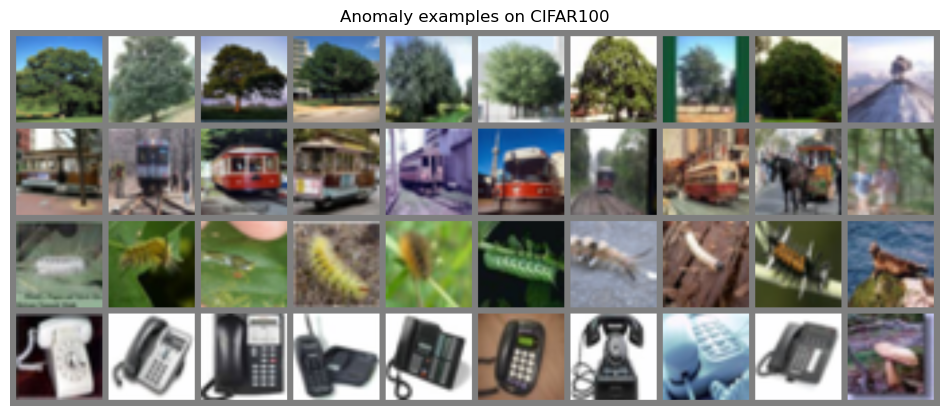

In [38]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS

    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

Train

In [63]:
def train_anomaly():
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=50,
                         gradient_clip_val=2)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
        args = ModelArgs()
        args.input_dim = train_anom_dataset.img_feats.shape[-1]
        args.dim = 512
        args.inter_dim = 1024
        args.n_heads= 4
        args.vocab_size = 1
        args.n_layers = 4

        model = AnomalyPredictor(args)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, train_anom_loader, verbose=False)
    val_result = trainer.test(model, val_anom_loader, verbose=False)
    test_result = trainer.test(model, test_anom_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "train_acc": train_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [64]:
anomaly_model, anomaly_result = train_anomaly( )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | transformer | Transformer | 7.5 M  | train
1 | output_net  | Sequential  | 264 K  | train
----------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.021    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [65]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 98.23%
Val accuracy:   93.44%
Test accuracy:  93.07%


In [67]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
    preds = anomaly_model.forward(inp_data, mask=None, start_pos=0)
    preds = F.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permut input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:,permut]
    perm_preds = anomaly_model.forward(perm_inp_data, mask=None, start_pos=0)
    perm_preds = F.softmax(perm_preds.squeeze(dim=-1), dim=-1)

assert (preds[:,permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

Preds
 [2.8289362e-06 4.2668128e-07 4.3620446e-07 2.3669096e-05 9.9996388e-01
 4.0015084e-07 2.2015415e-06 4.4325179e-06 4.8540130e-07 1.1356442e-06]
Permuted preds
 [2.8289310e-06 4.2668091e-07 4.3620406e-07 2.3669030e-05 9.9996400e-01
 4.0015090e-07 2.2015397e-06 4.4325143e-06 4.8540136e-07 1.1356433e-06]


In [68]:
attention_maps = anomaly_model.get_attention_maps(inp_data, mask=None, start_pos=0)
predictions = preds.argmax(dim=-1)

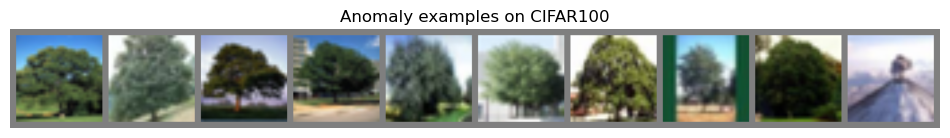

Prediction: 9


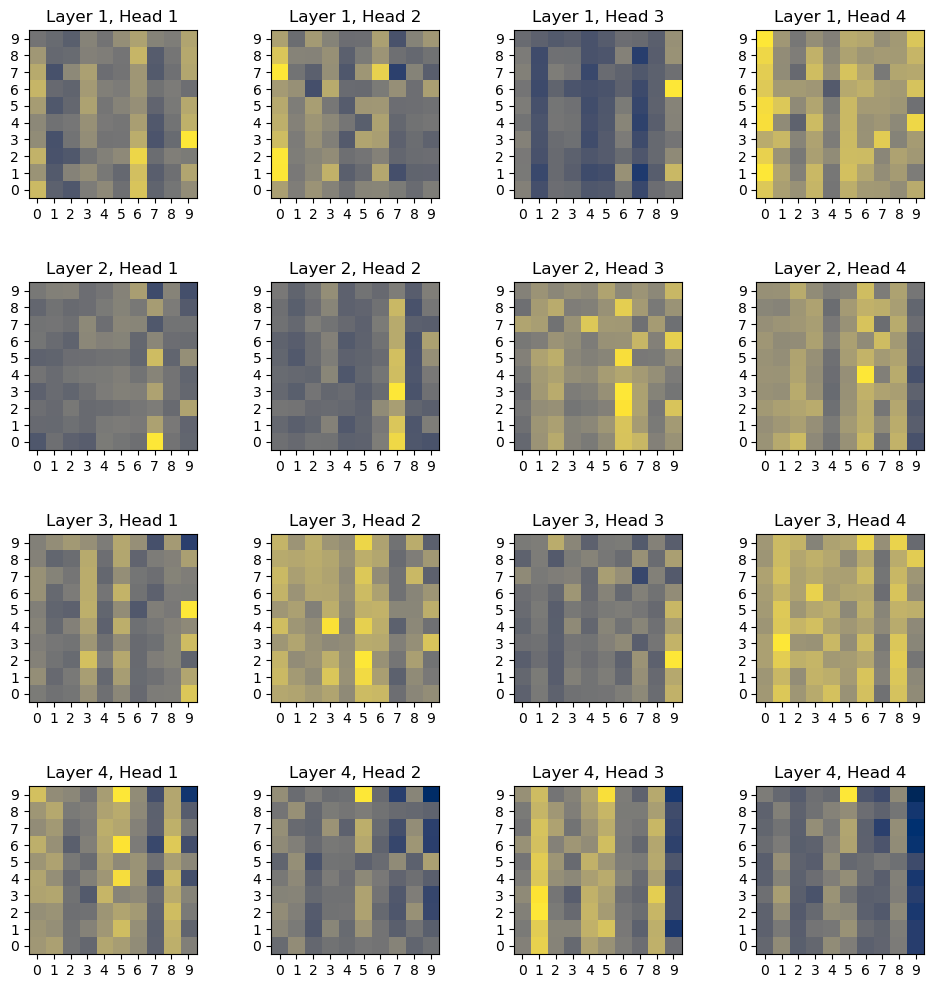

In [69]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

In [70]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)

Indices with mistake: [   1   49   84   92  114  115  168  185  196  212  213  221  284  289
  302  310  329  336  347  349  373  395  399  412  438  439  448  456
  466  470  488  491  506  514  529  537  551  590  600  627  638  644
  668  702  703  713  717  732  742  756  764  773  782  789  822  847
  862  884  886  936  940  948  962 1009]


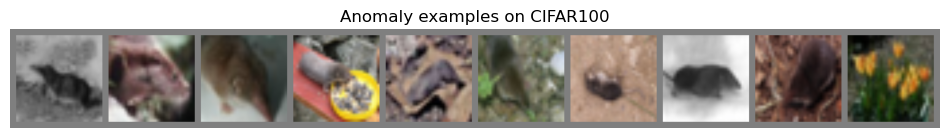

Prediction: 0


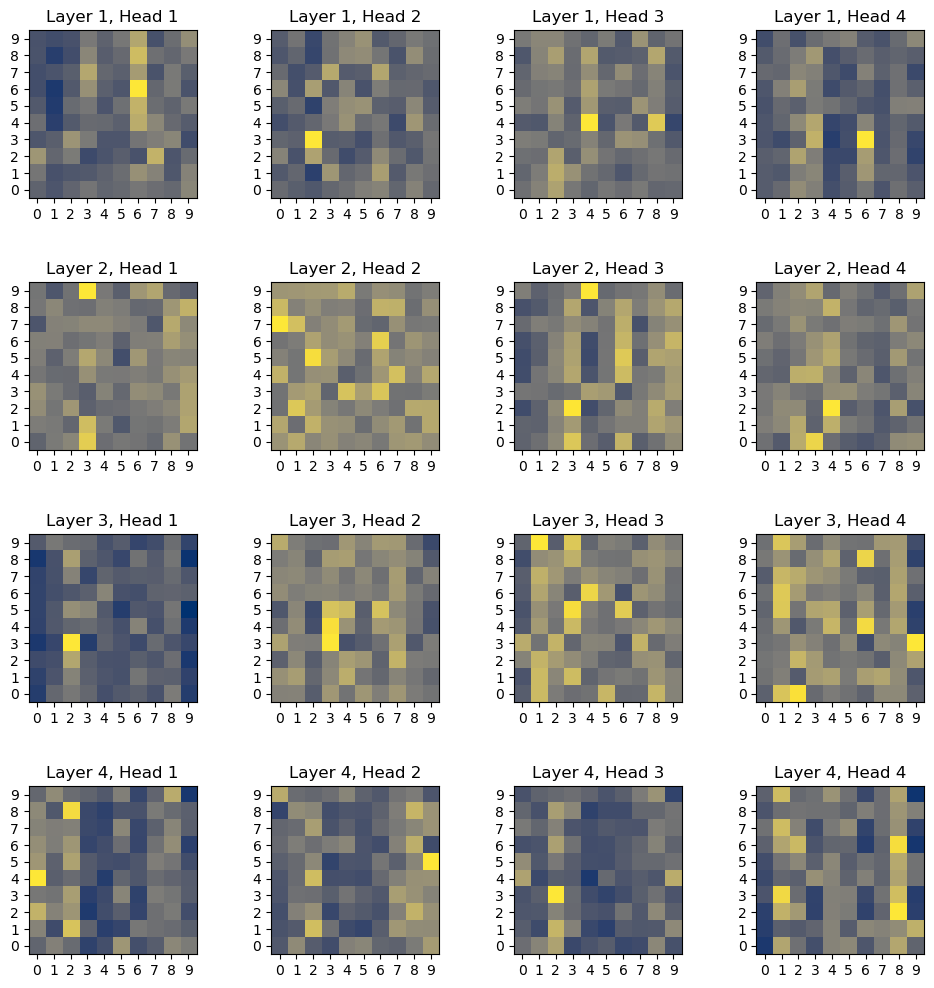

Probabilities:
Image 0: 66.54%
Image 1: 0.00%
Image 2: 0.00%
Image 3: 0.02%
Image 4: 0.00%
Image 5: 0.00%
Image 6: 0.94%
Image 7: 0.00%
Image 8: 0.00%
Image 9: 32.49%


In [71]:
visualize_prediction(mistakes[-1])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
    print(f"Image {i}: {100.0*p:4.2f}%")

In [ ]:
class DyT(nn.Module):
    def __init__(self, num_features, alpha_init_value=0.5):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(1) * alpha_init_value)
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))
    
    def forward(self, x):
        x = torch.tanh(self.alpha * x)
        return x * self.weight + self.bias